# Generalized (approximate) Minkowski Decomposition (vertically monotonically increasing component and low TV component + bound constraints)

This script illustate how to set up constraints and project a 2D model onto an intersection
of an intersection and a Minkowski sum of intersections of sets

Start with the setup:

In [14]:
using SetIntersectionProjection
using MAT
using LinearAlgebra
using PyPlot

mutable struct compgrid
  d :: Tuple
  n :: Tuple
end

#PARSDMM options:
options=PARSDMM_options()
options.FL=Float32
options=default_PARSDMM_options(options,options.FL)

#optional: fine-tune options for the projection algorithm
# options.adjust_gamma           = true
# options.adjust_rho             = true
# options.adjust_feasibility_rho = true
# options.Blas_active            = true
# options.maxit                  = 500

options.feas_tol     = 0.001
options.obj_tol      = 0.001
options.evol_rel_tol = 0.00001
# set_zero_subnormals(true)
BLAS.set_num_threads(2)

#select working precision
if options.FL==Float64
  TF = Float64
  TI = Int64
elseif options.FL==Float32
  TF = Float32
  TI = Int32
end

Int32

Load image (a P-wave velocity model) and set up computational grid

In [15]:
#load image to project
file = matopen(joinpath(dirname(pathof(SetIntersectionProjection)), "../examples/Data/compass_velocity.mat"))
m    = read(file, "Data");close(file)
m    = m[1:341,200:600]
m    = permutedims(m,[2,1])

#set up computational grid (25 and 6 m are the original distances between grid points)
comp_grid = compgrid((TF(25.0), TF(6.0)),(size(m,1), size(m,2)))
m         = convert(Vector{TF},vec(m))

#define axis limits and colorbar limits
xmax = comp_grid.d[1]*comp_grid.n[1]
zmax = comp_grid.d[2]*comp_grid.n[2]
vmi  = 1500.0
vma  = 4500.0

4500.0

Set up the Generalized Minkowski constraint

In [16]:
#####################################################################################################
# approximate monotonically increasing velocity with depth + TV decomposition #######################

#constraints for total model (sum of two compontents)
constraint_sum = Vector{SetIntersectionProjection.set_definitions}()

#bounds:
m_min     = 1500.0
m_max     = 4500.0
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#constraints for component 1 of the model
constraint_c1 = Vector{SetIntersectionProjection.set_definitions}()

#bounds component 1:
m_min     = 1500f0.*ones(TF,comp_grid.n)
m_max     = 4500f0.*ones(TF,comp_grid.n)
m_max[:,1:35] .= 1500f0
m_min     = vec(m_min)
m_max     = vec(m_max)
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#slope constraints component 1(vertical)
m_min     = 0.0
m_max     = 1e6
set_type  = "bounds"
TD_OP     = "D_z"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#constraints for component 2 of the model
constraint_c2 = Vector{SetIntersectionProjection.set_definitions}()

#bounds component 2:
m_min     = -1500.0
m_max     = 1500.0
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#TV constraint component 2
m_min     = 0
(TV,dummy1,dummy2,dummy3) = get_TD_operator(comp_grid,"TV",options.FL)
m_max = 0.15f0*norm(TV*vec(m),1)
set_type  = "l1"
TD_OP     = "TV"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#get all projectors for sub-problems and linear operators
(P_sub_sum,TD_OP_sum,set_Prop_sum) = setup_constraints(constraint_sum,comp_grid,options.FL)
(P_sub_c1,TD_OP_c1,set_Prop_c1)    = setup_constraints(constraint_c1,comp_grid,options.FL)
(P_sub_c2,TD_OP_c2,set_Prop_c2)    = setup_constraints(constraint_c2,comp_grid,options.FL)

#pre-computations
options.Minkowski      = true
options.zero_ini_guess = true
(TD_OP,set_Prop,AtA,l,y) = PARSDMM_precompute_distribute_Minkowski(TD_OP_c1,TD_OP_c2,TD_OP_sum,set_Prop_c1,set_Prop_c2,set_Prop_sum,comp_grid,options)

#put all projectors for sub-problems in a vector
P_sub = deepcopy(P_sub_c1);
append!(P_sub,P_sub_c2)
append!(P_sub,P_sub_sum)

5-element Array{Any,1}:
 #170 (generic function with 1 method)
 #170 (generic function with 1 method)
 #170 (generic function with 1 method)
 #174 (generic function with 1 method)
 #170 (generic function with 1 method)

Compute projection and plot results

stationary objective and reached feasibility, exiting PARSDMM (iteration 140)
 20.897335 seconds (107.04 k allocations: 7.398 GiB, 9.37% gc time)


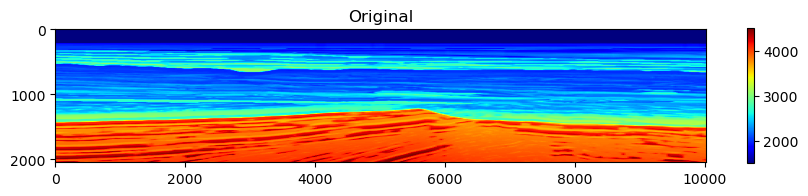

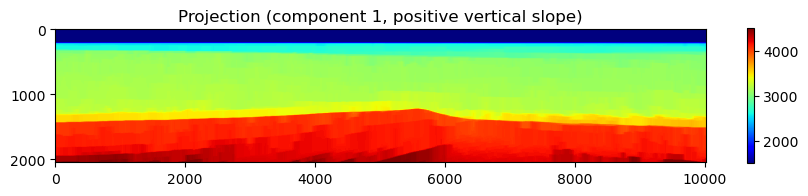

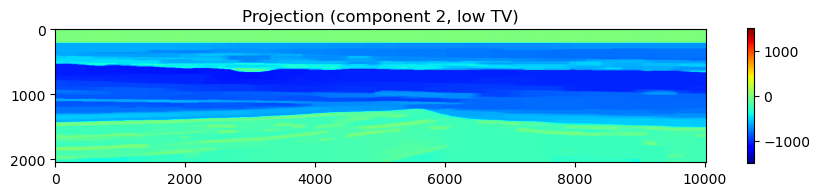

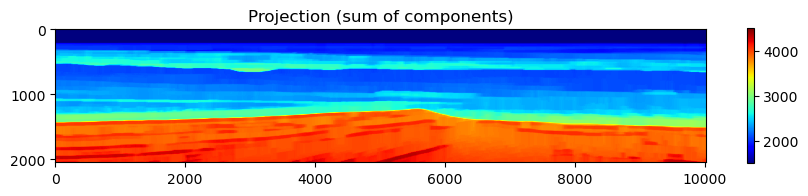

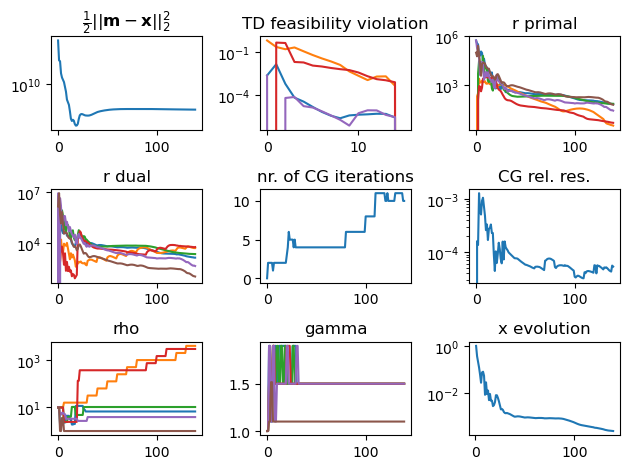

stationary objective and reached feasibility, exiting PARSDMM (iteration 140)
 21.055466 seconds (107.15 k allocations: 7.398 GiB, 8.96% gc time)


In [17]:
#project
@time (x,log_PARSDMM) = PARSDMM(m,AtA,TD_OP,set_Prop,P_sub,comp_grid,options);
@time (x,log_PARSDMM) = PARSDMM(m,AtA,TD_OP,set_Prop,P_sub,comp_grid,options);


#plot; output is component 1 (m1), component 2 (m2) stacked in a vector
m1 = x[1:length(m)]
m2 = x[1+length(m):end]
ms = m1+m2; #total model output

figure(figsize=(10.5,1.75));
imshow(permutedims(reshape(m,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar();title("Original")
savefig("original_model.png",bbox_inches="tight")
figure(figsize=(10.5,1.75));imshow(permutedims(reshape(m1,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (component 1, positive vertical slope)")
savefig("projected_model_component1.png",bbox_inches="tight")
figure(figsize=(10.5,1.75));imshow(permutedims(reshape(m2,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=-1500,vmax=1500,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (component 2, low TV)")
savefig("projected_model_component2.png",bbox_inches="tight")
figure(figsize=(10.5,1.75));imshow(permutedims(reshape(ms,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (sum of components)")
savefig("projected_model_component_sum.png",bbox_inches="tight")

figure();
subplot(3, 3, 3);semilogy(log_PARSDMM.r_pri)          ;title("r primal")
subplot(3, 3, 4);semilogy(log_PARSDMM.r_dual)         ;title("r dual")
subplot(3, 3, 1);semilogy(log_PARSDMM.obj)            ;title(L"$ \frac{1}{2} || \mathbf{m}-\mathbf{x} ||_2^2 $")
subplot(3, 3, 2);semilogy(log_PARSDMM.set_feasibility);title("TD feasibility violation")
subplot(3, 3, 5);plot(log_PARSDMM.cg_it)              ;title("nr. of CG iterations")
subplot(3, 3, 6);semilogy(log_PARSDMM.cg_relres)      ;title("CG rel. res.")
subplot(3, 3, 7);semilogy(log_PARSDMM.rho)            ;title("rho")
subplot(3, 3, 8);plot(log_PARSDMM.gamma)              ;title("gamma")
subplot(3, 3, 9);semilogy(log_PARSDMM.evol_x)         ;title("x evolution")
tight_layout()
#tight_layout(pad=0.0, w_pad=0.0, h_pad=1.0)
savefig("PARSDMM_logs.png",bbox_inches="tight")

# Generalized Minkowski Decomposition (monotonically increasing and decreasing components in the vertical direction + bound constraints)

stationary objective and reached feasibility, exiting PARSDMM (iteration 120)
 19.795014 seconds (137.38 k allocations: 5.140 GiB, 7.87% gc time)


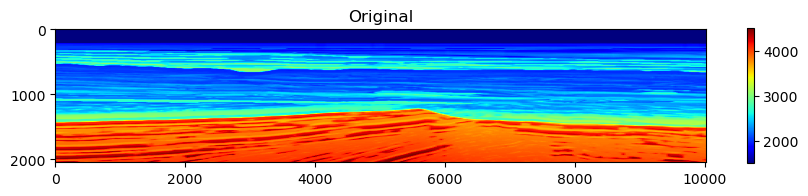

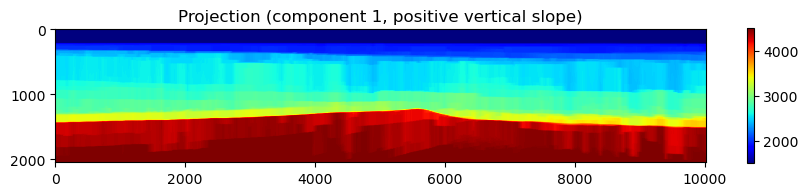

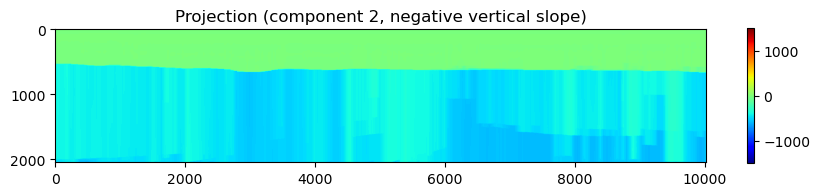

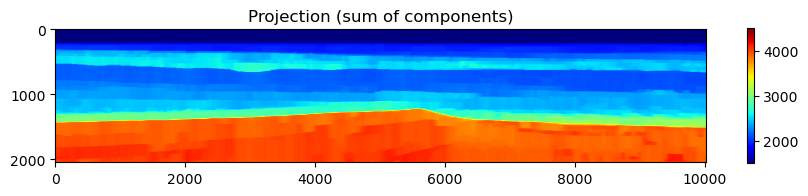

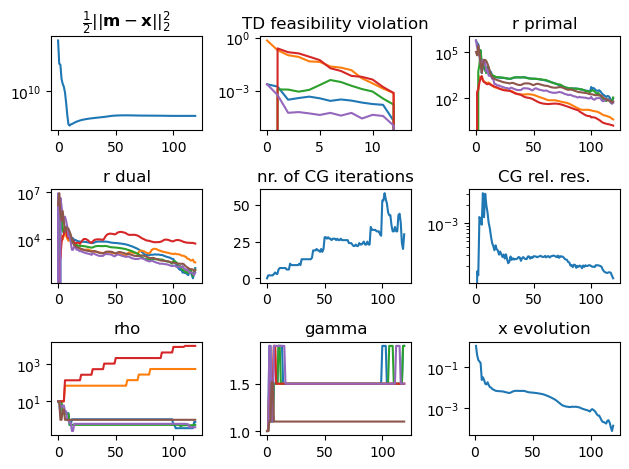

stationary objective and reached feasibility, exiting PARSDMM (iteration 120)
 20.964102 seconds (137.51 k allocations: 5.140 GiB, 7.79% gc time)


In [18]:
#################################################################################################################################
# approximate monotonically increasing velocity with depth + monotonically decreasing velocity with depth #######################

#constraints for total model
constraint_sum = Vector{SetIntersectionProjection.set_definitions}()

#bounds:
m_min     = 1500.0
m_max     = 4500.0
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#constraints for component 1 of the model
constraint_c1 = Vector{SetIntersectionProjection.set_definitions}()

#bounds component 1:
m_min     = 1500.0f0*ones(TF,prod(comp_grid.n))
m_max     = 4500.0f0.*ones(TF,comp_grid.n)
m_max[:,1:35] .= 1500.0f0
m_max     = vec(m_max)
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#slope constraints component 1(vertical, positive)
m_min     = 0.0
m_max     = 1e6
set_type  = "bounds"
TD_OP     = "D_z"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#constraints for component 2 of the model
constraint_c2 = Vector{SetIntersectionProjection.set_definitions}()

#bounds component 2:
m_min     = -3000.0
m_max     = 0.0
set_type  = "bounds"
TD_OP     = "identity"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

#slope constraints component 1(vertical, negative)
m_min     = -1e6
m_max     = 0.0
set_type  = "bounds"
TD_OP     = "D_z"
app_mode  = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

(P_sub_sum,TD_OP_sum,set_Prop_sum) = setup_constraints(constraint_sum,comp_grid,options.FL)
(P_sub_c1,TD_OP_c1,set_Prop_c1) = setup_constraints(constraint_c1,comp_grid,options.FL)
(P_sub_c2,TD_OP_c2,set_Prop_c2) = setup_constraints(constraint_c2,comp_grid,options.FL)

options.parallel  = false
options.Minkowski = true
(TD_OP,set_Prop,AtA,l,y) = PARSDMM_precompute_distribute_Minkowski(TD_OP_c1,TD_OP_c2,TD_OP_sum,set_Prop_c1,set_Prop_c2,set_Prop_sum,comp_grid,options)

P_sub = deepcopy(P_sub_c1);
append!(P_sub,P_sub_c2)
append!(P_sub,P_sub_sum)

options.zero_ini_guess=true

@time (x,log_PARSDMM) = PARSDMM(m,AtA,TD_OP,set_Prop,P_sub,comp_grid,options);
@time (x,log_PARSDMM) = PARSDMM(m,AtA,TD_OP,set_Prop,P_sub,comp_grid,options);

#plot
m1 = x[1:length(m)]
m2 = x[1+length(m):end]
ms = m1+m2;

figure(figsize=(10.5,1.75));imshow(permutedims(reshape(m,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar();title("Original")
savefig("original_model.png",bbox_inches="tight")
figure(figsize=(10.5,1.75));imshow(permutedims(reshape(m1,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (component 1, positive vertical slope)")
savefig("projected_model_component1.png",bbox_inches="tight")
figure(figsize=(10.5,1.75));imshow(permutedims(reshape(m2,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=-1500,vmax=1500,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (component 2, negative vertical slope)")
savefig("projected_model_component2.png",bbox_inches="tight")
figure(figsize=(10.5,1.75));imshow(permutedims(reshape(ms,(comp_grid.n[1],comp_grid.n[2])),[2,1]),cmap="jet",vmin=vmi,vmax=vma,extent=[0,  xmax, zmax, 0]);colorbar(); title("Projection (sum of components)")
savefig("projected_model_component_sum.png",bbox_inches="tight")

figure();
subplot(3, 3, 3);semilogy(log_PARSDMM.r_pri)          ;title("r primal")
subplot(3, 3, 4);semilogy(log_PARSDMM.r_dual)         ;title("r dual")
subplot(3, 3, 1);semilogy(log_PARSDMM.obj)            ;title(L"$ \frac{1}{2} || \mathbf{m}-\mathbf{x} ||_2^2 $")
subplot(3, 3, 2);semilogy(log_PARSDMM.set_feasibility);title("TD feasibility violation")
subplot(3, 3, 5);plot(log_PARSDMM.cg_it)              ;title("nr. of CG iterations")
subplot(3, 3, 6);semilogy(log_PARSDMM.cg_relres)      ;title("CG rel. res.")
subplot(3, 3, 7);semilogy(log_PARSDMM.rho)            ;title("rho")
subplot(3, 3, 8);plot(log_PARSDMM.gamma)              ;title("gamma")
subplot(3, 3, 9);semilogy(log_PARSDMM.evol_x)         ;title("x evolution")
tight_layout()
#tight_layout(pad=0.0, w_pad=0.0, h_pad=1.0)
savefig("PARSDMM_logs.png",bbox_inches="tight")